In [25]:
import requests
from bs4 import BeautifulSoup
from retry import retry
import urllib
import time


import pandas as pd
import numpy as np
import copy
import re
import matplotlib.pyplot as plt
import seaborn as sns
import japanize_matplotlib

In [4]:
# 複数ページの情報をまとめて取得
data_samples = []

# スクレイピングするページ数
max_page = 3
# SUUMOを東京都23区のみ指定して検索して出力した画面のurl(ページ数フォーマットが必要)
url = 'https://suumo.jp/jj/chintai/ichiran/FR301FC001/?ar=030&bs=040&ta=13&sc=13101&sc=13102&sc=13103&sc=13104&sc=13105&sc=13113&sc=13106&sc=13107&sc=13108&sc=13118&sc=13121&sc=13122&sc=13123&sc=13109&sc=13110&sc=13111&sc=13112&sc=13114&sc=13115&sc=13120&sc=13116&sc=13117&sc=13119&cb=0.0&ct=9999999&mb=0&mt=9999999&et=9999999&cn=9999999&shkr1=03&shkr2=03&shkr3=03&shkr4=03&sngz=&po1=25&pc=50&page={}'

# リクエストがうまく行かないパターンを回避するためのやり直し
@retry(tries=3, delay=10, backoff=2)
def load_page(url):
    html = requests.get(url)
    soup = BeautifulSoup(html.content, 'html.parser')
    return soup

# 処理時間を測りたい
start = time.time()
times = []

# ページごとの処理
for page in range(1,max_page+1):
    before = time.time()
    # ページ情報
    soup = load_page(url.format(page))
    # 物件情報リストを指定
    mother = soup.find_all(class_='cassetteitem')
    
    # 物件ごとの処理
    for child in mother:

        # 建物情報
        data_home = []
        # カテゴリ
        data_home.append(child.find(class_='ui-pct ui-pct--util1').text)
        # 建物名
        data_home.append(child.find(class_='cassetteitem_content-title').text)
        # 住所
        data_home.append(child.find(class_='cassetteitem_detail-col1').text)
        # 最寄り駅のアクセス
        children = child.find(class_='cassetteitem_detail-col2')
        for id,grandchild in enumerate(children.find_all(class_='cassetteitem_detail-text')):
            data_home.append(grandchild.text)
        # 築年数と階数
        children = child.find(class_='cassetteitem_detail-col3')
        for grandchild in children.find_all('div'):
            data_home.append(grandchild.text)

        # 部屋情報
        rooms = child.find(class_='cassetteitem_other')
        for room in rooms.find_all(class_='js-cassette_link'):
            data_room = []
            
            # 部屋情報が入っている表を探索
            for id_, grandchild in enumerate(room.find_all('td')):
                # 階
                if id_ == 2:
                    data_room.append(grandchild.text.strip())
                # 家賃と管理費
                elif id_ == 3:
                    data_room.append(grandchild.find(class_='cassetteitem_other-emphasis ui-text--bold').text)
                    data_room.append(grandchild.find(class_='cassetteitem_price cassetteitem_price--administration').text)
                # 敷金と礼金
                elif id_ == 4:
                    data_room.append(grandchild.find(class_='cassetteitem_price cassetteitem_price--deposit').text)
                    data_room.append(grandchild.find(class_='cassetteitem_price cassetteitem_price--gratuity').text)
                # 間取りと面積
                elif id_ == 5:
                    data_room.append(grandchild.find(class_='cassetteitem_madori').text)
                    data_room.append(grandchild.find(class_='cassetteitem_menseki').text)
                # url
                elif id_ == 8:
                    get_url = grandchild.find(class_='js-cassette_link_href cassetteitem_other-linktext').get('href')
                    abs_url = urllib.parse.urljoin(url,get_url)
                    data_room.append(abs_url)
            # 物件情報と部屋情報をくっつける
            data_sample = data_home + data_room
            data_samples.append(data_sample)
    
    # 1アクセスごとに1秒休む
    time.sleep(1)
    
    # 進捗確認
    # このページの作業時間を表示
    after = time.time()
    running_time = after - before
    times.append(running_time)
    print(f'{page}ページ目：{running_time}秒')
    # 取得した件数
    print(f'総取得件数：{len(data_samples)}')
    # 作業進捗
    complete_ratio = round(page/max_page*100,3)
    print(f'完了：{complete_ratio}%')
    # 作業の残り時間目安を表示
    running_mean = np.mean(times)
    running_required_time = running_mean * (max_page - page)
    hour = int(running_required_time/3600)
    minute = int((running_required_time%3600)/60)
    second = int(running_required_time%60)
    print(f'残り時間：{hour}時間{minute}分{second}秒\n')

# 音を出す
def sound():
    !rundll32 user32.dll,MessageBeep
    
# 処理時間を測りたい
finish = time.time()
running_all = finish - start
print('総経過時間：',running_all)
sound()


1ページ目：6.060125350952148秒
総取得件数：185
完了：33.333%
残り時間：0時間0分12秒

2ページ目：5.900315046310425秒
総取得件数：372
完了：66.667%
残り時間：0時間0分5秒

3ページ目：6.838330984115601秒
総取得件数：678
完了：100.0%
残り時間：0時間0分0秒

総経過時間： 18.80091881752014


In [119]:
columns = ['カテゴリ','建物名','住所','最寄り駅1','最寄り駅2','最寄り駅3','築年数','階数','階','賃料','管理費','敷金','礼金','間取り','専有面積','url']
suumo_tokyo = pd.DataFrame(data_samples, columns=columns)

In [290]:
suumo_tokyo

,カテゴリ,建物名,住所,最寄り駅1,最寄り駅2,最寄り駅3,築年数,階数,階,賃料,管理費,敷金,礼金,間取り,専有面積,url,経度,緯度
0,賃貸アパート,プチ・ボヌール,東京都大田区南蒲田３,京急空港線/糀谷駅 歩7分,京急本線/京急蒲田駅 歩10分,京急本線/雑色駅 歩16分,築4年,2階建,2階,14.8万円,5000円,14.8万円,14.8万円,42DK,48.87m2,https://suumo.jp/chintai/jnc_000046696863/?bc=...,139.726883,35.554230
1,賃貸一戸建て,荒川戸建,東京都荒川区荒川２,東京メトロ千代田線/町屋駅 歩5分,京成本線/新三河島駅 歩12分,ＪＲ常磐線/三河島駅 歩15分,築10年,3階建,1-3階,19.5万円,-,39万円,19.5万円,3SLDK,97.95m2,https://suumo.jp/chintai/jnc_000076009318/?bc=...,139.783234,35.737568
2,賃貸一戸建て,荒川戸建,東京都荒川区荒川２,東京メトロ千代田線/町屋駅 歩5分,京成本線/新三河島駅 歩12分,ＪＲ常磐線/三河島駅 歩15分,築10年,3階建,1-3階,19.5万円,-,39万円,19.5万円,3SLDK,97.95m2,https://suumo.jp/chintai/jnc_000076047600/?bc=...,139.783234,35.737568
3,賃貸マンション,ティモーネ上野の森ノース,東京都荒川区東日暮里４,ＪＲ山手線/鶯谷駅 歩6分,東京メトロ日比谷線/入谷駅 歩11分,ＪＲ山手線/日暮里駅 歩13分,築5年,11階建,2階,15.2万円,10000円,15.2万円,15.2万円,2LDK,52.04m2,https://suumo.jp/chintai/jnc_000077318759/?bc=...,139.780899,35.726601
4,賃貸アパート,東京メトロ日比谷線 三ノ輪駅 3階建 築13年,東京都荒川区南千住５,東京メトロ日比谷線/三ノ輪駅 歩5分,ＪＲ常磐線/南千住駅 歩7分,京成本線/千住大橋駅 歩15分,築13年,3階建,3階,11.3万円,2000円,11.3万円,11.3万円,1LDK,43.81m2,https://suumo.jp/chintai/jnc_000077330023/?bc=...,139.795654,35.733616
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
222918,賃貸一戸建て,中澤貸家,東京都江戸川区江戸川２,都営新宿線/瑞江駅 歩14分,NaN,NaN,築51年,2階建,1-2階,8.4万円,-,16.8万円,-,3K,52.87m2,https://suumo.jp/chintai/jnc_000070035188/?bc=...,139.902374,35.685436
222919,賃貸マンション,東京メトロ副都心線 雑司が谷駅 7階建 築37年,東京都豊島区高田１,東京メトロ副都心線/雑司が谷駅 歩4分,ＪＲ山手線/目白駅 歩11分,東京メトロ有楽町線/護国寺駅 歩15分,築37年,7階建,7階,9.2万円,8000円,9.2万円,9.2万円,1DK,26.04m2,https://suumo.jp/chintai/jnc_000074167859/?bc=...,139.716156,35.715145
222920,賃貸アパート,ハイツ南大井,東京都品川区南大井５,京急本線/立会川駅 歩7分,ＪＲ京浜東北線/大井町駅 歩14分,ＪＲ京浜東北線/大森駅 歩14分,築20年,2階建,1階,8.5万円,3000円,8.5万円,8.5万円,ワンルーム,28.56m2,https://suumo.jp/chintai/jnc_000043176296/?bc=...,139.734222,35.596874
222921,賃貸マンション,芦間ハイツ,東京都葛飾区東新小岩１,ＪＲ総武線/新小岩駅 歩3分,NaN,NaN,築45年,3階建,3階,7.5万円,-,7.5万円,7.5万円,1DK,30.36m2,https://suumo.jp/chintai/jnc_000040819257/?bc=...,139.861359,35.720612


In [3]:
suumo_tokyo.to_csv(f'suumo{max_page}.csv', columns=columns, index=False)

NameError: name 'suumo_tokyo' is not defined

In [286]:
max_page = 2000
suumo_tokyo = pd.read_csv(f'suumo{max_page}.csv')

In [291]:
# 管理費（正規表現）
suumo_tokyo['管理費']

# 管理費の'-'を0に置き換える
suumo_tokyo.loc[suumo_tokyo['管理費']=="-",'管理費'] = suumo_tokyo.loc[suumo_tokyo['管理費']=="-",'管理費'].replace('-','0')

# 数字+文字→数字
def numobj_num(x):
    return re.sub(r'([0-9]+)\w+',r'\1',x)

# ????円→????
suumo_tokyo['管理費'] = suumo_tokyo['管理費'].map(lambda x: numobj_num(x))
# 整数型に変更
suumo_tokyo['管理費'] = suumo_tokyo['管理費'].astype(int)

In [292]:
# 築年数（正規表現）

# 新築は築0年ということにする
suumo_tokyo.loc[suumo_tokyo['築年数']=='新築','築年数'] = '築0年'

# 文字+数字+文字→数字
def objnumobj_num(x):
    return re.sub(r'\w+?([0-9]+)\w+',r'\1',x)

# 築??年(以上)→??
# 99階以上は99階に圧縮されます
suumo_tokyo['築年数'] = suumo_tokyo['築年数'] = suumo_tokyo['築年数'].map(lambda x: objnumobj_num(x))

# 
suumo_tokyo['築年数'] = suumo_tokyo['築年数'].astype(int)

In [293]:
# 地下変数（正規表現）

# 平屋は1階建ということにする
suumo_tokyo.loc[suumo_tokyo['階数']=='平屋','階数'] = '1階建'

# この文字列ありますか？関数
def search_object(search,object):
    return bool(re.search(search,object))

# 地下何階までありますか？関数
def underground(x):
    return search_object('地下',x)*objnumobj_num(x)+(1-search_object('地下',x))*'0'
    
# 地下がなければ０、あるなら何階まであるか
suumo_tokyo['地下'] = suumo_tokyo['階数'].map(lambda x: underground(x))

# int型に変換
suumo_tokyo['地下'] = suumo_tokyo['地下'].astype('int')

In [294]:
# 地上変数(正規表現)
suumo_tokyo['階数']

# 平屋は1階建ということにする
suumo_tokyo.loc[suumo_tokyo['階数']=='平屋','階数'] = '1階建'

# 最後の数字列を取り出す
def lastnum(x):
    return re.findall('[0-9]+',x)[-1]

# ??階建→??
suumo_tokyo['地上'] = suumo_tokyo['階数'].map(lambda x: lastnum(x))

# int型に変換
suumo_tokyo['地上'] = suumo_tokyo['地上'].astype(int)

In [295]:
# 階数変数は地下地上の合算にしておく
suumo_tokyo['階数'] = suumo_tokyo['地上'] + suumo_tokyo['地下']

In [296]:
# 階変数(正規表現)

# - は1階ってことにする
suumo_tokyo.loc[suumo_tokyo['階']=='-','階'] = '1階'

# (文字)数字を取り出す
def get_objnum(x):
    return re.search(r'([A-Z]?)([0-9]+)',x).group()

# 階の前処理 -があればその後ろ、なければ(文字)数字
def floor(x):
    return search_object('-',x)*lastnum(x)+(1-search_object('-',x))*get_objnum(x)
# B? → -?,Bがなければそのまま
def basement_floor(x):
    return search_object('B',x)*('-'+re.search(r'[0-9]+',x).group())+(1-search_object('B',x))*(x)
# M? → ?.5 Mがなければそのまま
def middle_floor(x):
    return search_object('M',x)*(re.search(r'[0-9]+',x).group()+'.5')+(1-search_object('M',x))*(x)
   
# 上の処理を適用する
suumo_tokyo['階'] = suumo_tokyo['階'].map(lambda x: floor(x)).map(lambda x: basement_floor(x)).map(lambda x: middle_floor(x))

# float型に変換
suumo_tokyo['階'] = suumo_tokyo['階'].astype(float)

In [297]:
# 賃料変数(正規表現)
# 10000倍するかは諸説

# ???万円→???
def drop_man(x):
    return re.sub(r'([0-9]+)万円',r'\1',x)

# 賃料から万円を除去
suumo_tokyo['賃料'] = suumo_tokyo['賃料'].map(lambda x: drop_man(x))
# float型に変換
suumo_tokyo['賃料'] = suumo_tokyo['賃料'].astype(float)

In [298]:
# 礼金変数(正規表現)
# 10000倍するかは諸説

# '-'は0万円ってことにする
suumo_tokyo.loc[suumo_tokyo['敷金']=='-','敷金'] = '0万円'

# 敷金から万円を除去
suumo_tokyo['敷金'] = suumo_tokyo['敷金'].map(lambda x: drop_man(x))
# float型に変換
suumo_tokyo['敷金'] = suumo_tokyo['敷金'].astype(float)

In [299]:
# 礼金変数(正規表現)
# 10000倍するかは諸説

# '-'は0万円ってことにする
suumo_tokyo.loc[suumo_tokyo['礼金']=='-','礼金'] = '0万円'

# 礼金から万円を除去
suumo_tokyo['礼金'] = suumo_tokyo['礼金'].map(lambda x: drop_man(x))
# float型に変換
suumo_tokyo['礼金'] = suumo_tokyo['礼金'].astype(float)

In [300]:
# 間取り変換案
# そのまま
# 部屋数、onehot(L,D,K)に変換

In [301]:
# 専有面積変数（正規表現）

# 英字以降を切り落とす
def drop_behind_alfa(x):
    return re.sub('[a-z]\w+','',x)
# ????m2 → ????
suumo_tokyo['専有面積'] = suumo_tokyo['専有面積'].map(lambda x: drop_behind_alfa(x))
# float型に変換
suumo_tokyo['専有面積'] = suumo_tokyo['専有面積'].astype(float)

In [302]:
# 住所変数（正規表現）

# ～都,～区,～ に分けたい
# ついでに[都道府県][市区町村][以下]に対応したい

x = suumo_tokyo.loc[0,'住所']

# 住所を(都道府県)(市区町村)(市区町村以下)に分けて取り出す
def split_address(x):
    a,b,c = re.search('(...??[都道府県])(.+?[市区町村])(.+)',x).groups()
    return a,b,c

# 一応分割できたっぽい
suumo_tokyo[['都道府県','市区町村','市区町村以下']] = suumo_tokyo.apply(lambda x:split_address(x.住所),axis=1,result_type='expand')

In [37]:
# 住所→緯度経度変換装置

import requests
import urllib

def translate_address_coordinates(address):
    makeUrl = "https://msearch.gsi.go.jp/address-search/AddressSearch?q="
    s_quote = urllib.parse.quote(address)
    response = requests.get(makeUrl + s_quote)
    return response.json()[0]["geometry"]["coordinates"]

In [108]:
# 住所のuniqueから緯度経度を取得
# csvに変換しておいたので2回目は不要　coordinates.csvを呼び出そう

all_addresses = {}
running_times = []
i = 0

for address in suumo_tokyo['住所'].unique():
    
    start = time.time()

    coordinate = translate_address_coordinates(address)
    all_addresses[address] = coordinate
    time.sleep(1)
    
    finish = time.time()
    
    running_time = finish - start
    running_times.append(running_time)

    all_count = suumo_tokyo['住所'].unique().shape[0]
    print(f'{i}件目：{running_time}秒')
    # 作業進捗
    complete_ratio = round(i/all_count*100,3)
    print(f'完了：{complete_ratio}%')
    # 作業の残り時間目安を表示
    running_mean = np.mean(running_times)
    running_required_time = running_mean * (all_count - i)
    hour = int(running_required_time/3600)
    minute = int((running_required_time%3600)/60)
    second = int(running_required_time%60)
    print(f'残り時間：{hour}時間{minute}分{second}秒\n')
    i += 1

0件目：1.0898034572601318秒
完了：0.0%
残り時間：0時間53分37秒

1件目：1.1213340759277344秒
完了：0.034%
残り時間：0時間54分22秒

2件目：1.1321437358856201秒
完了：0.068%
残り時間：0時間54分47秒

3件目：1.1079161167144775秒
完了：0.102%
残り時間：0時間54分41秒

4件目：1.147125482559204秒
完了：0.136%
残り時間：0時間55分0秒

5件目：1.1107919216156006秒
完了：0.169%
残り時間：0時間54分55秒

6件目：1.1138942241668701秒
完了：0.203%
残り時間：0時間54分52秒

7件目：1.1122925281524658秒
完了：0.237%
残り時間：0時間54分49秒

8件目：1.1129944324493408秒
完了：0.271%
残り時間：0時間54分46秒

9件目：1.1260590553283691秒
完了：0.305%
残り時間：0時間54分48秒

10件目：1.1136188507080078秒
完了：0.339%
残り時間：0時間54分46秒

11件目：1.13250732421875秒
完了：0.373%
残り時間：0時間54分49秒

12件目：1.0979628562927246秒
完了：0.407%
残り時間：0時間54分43秒

13件目：1.1303660869598389秒
完了：0.44%
残り時間：0時間54分45秒

14件目：1.1343801021575928秒
完了：0.474%
残り時間：0時間54分47秒

15件目：1.116408348083496秒
完了：0.508%
残り時間：0時間54分45秒

16件目：1.1167511940002441秒
完了：0.542%
残り時間：0時間54分44秒

17件目：1.098921298980713秒
完了：0.576%
残り時間：0時間54分39秒

18件目：1.1152005195617676秒
完了：0.61%
残り時間：0時間54分38秒

19件目：1.1294786930084229秒
完了：0.644%
残り時間：0時間54分39秒



162件目：1.3290057182312012秒
完了：5.488%
残り時間：0時間54分31秒

163件目：1.1100528240203857秒
完了：5.522%
残り時間：0時間54分28秒

164件目：1.1425647735595703秒
完了：5.556%
残り時間：0時間54分27秒

165件目：2.520941972732544秒
完了：5.589%
残り時間：0時間54分48秒

166件目：1.113029956817627秒
完了：5.623%
残り時間：0時間54分46秒

167件目：1.0977783203125秒
完了：5.657%
残り時間：0時間54分43秒

168件目：1.174394130706787秒
完了：5.691%
残り時間：0時間54分42秒

169件目：1.143500566482544秒
完了：5.725%
残り時間：0時間54分40秒

170件目：1.1138293743133545秒
完了：5.759%
残り時間：0時間54分38秒

171件目：1.1196463108062744秒
完了：5.793%
残り時間：0時間54分36秒

172件目：1.127274990081787秒
完了：5.827%
残り時間：0時間54分34秒

173件目：1.123185396194458秒
完了：5.86%
残り時間：0時間54分32秒

174件目：1.123610019683838秒
完了：5.894%
残り時間：0時間54分30秒

175件目：1.1078479290008545秒
完了：5.928%
残り時間：0時間54分28秒

176件目：1.1480627059936523秒
完了：5.962%
残り時間：0時間54分26秒

177件目：1.5802600383758545秒
完了：5.996%
残り時間：0時間54分31秒

178件目：1.092170000076294秒
完了：6.03%
残り時間：0時間54分29秒

179件目：1.1063156127929688秒
完了：6.064%
残り時間：0時間54分26秒

180件目：1.113661527633667秒
完了：6.098%
残り時間：0時間54分24秒

181件目：1.1038219928741455秒


321件目：1.2344138622283936秒
完了：10.874%
残り時間：0時間51分31秒

322件目：1.109839916229248秒
完了：10.908%
残り時間：0時間51分29秒

323件目：1.1259880065917969秒
完了：10.942%
残り時間：0時間51分28秒

324件目：1.0938022136688232秒
完了：10.976%
残り時間：0時間51分26秒

325件目：1.0949053764343262秒
完了：11.009%
残り時間：0時間51分24秒

326件目：1.1313560009002686秒
完了：11.043%
残り時間：0時間51分22秒

327件目：1.120894432067871秒
完了：11.077%
残り時間：0時間51分21秒

328件目：1.1202483177185059秒
完了：11.111%
残り時間：0時間51分19秒

329件目：1.1116628646850586秒
完了：11.145%
残り時間：0時間51分18秒

330件目：1.1692657470703125秒
完了：11.179%
残り時間：0時間51分16秒

331件目：1.1581089496612549秒
完了：11.213%
残り時間：0時間51分15秒

332件目：1.1393001079559326秒
完了：11.247%
残り時間：0時間51分14秒

333件目：1.21063232421875秒
完了：11.28%
残り時間：0時間51分13秒

334件目：1.1354024410247803秒
完了：11.314%
残り時間：0時間51分11秒

335件目：1.129417896270752秒
完了：11.348%
残り時間：0時間51分10秒

336件目：1.1115598678588867秒
完了：11.382%
残り時間：0時間51分8秒

337件目：1.1412060260772705秒
完了：11.416%
残り時間：0時間51分7秒

338件目：1.1099958419799805秒
完了：11.45%
残り時間：0時間51分5秒

339件目：1.0947792530059814秒
完了：11.484%
残り時間：0時間51分3秒

340件

478件目：1.094569444656372秒
完了：16.192%
残り時間：0時間47分52秒

479件目：1.2103025913238525秒
完了：16.226%
残り時間：0時間47分51秒

480件目：1.1400961875915527秒
完了：16.26%
残り時間：0時間47分50秒

481件目：1.1324245929718018秒
完了：16.294%
残り時間：0時間47分48秒

482件目：1.1157453060150146秒
完了：16.328%
残り時間：0時間47分47秒

483件目：1.0999999046325684秒
完了：16.362%
残り時間：0時間47分45秒

484件目：1.0945584774017334秒
完了：16.396%
残り時間：0時間47分44秒

485件目：1.1394636631011963秒
完了：16.43%
残り時間：0時間47分43秒

486件目：1.1147704124450684秒
完了：16.463%
残り時間：0時間47分41秒

487件目：1.0973947048187256秒
完了：16.497%
残り時間：0時間47分40秒

488件目：1.1031086444854736秒
完了：16.531%
残り時間：0時間47分38秒

489件目：2.8202357292175293秒
完了：16.565%
残り時間：0時間47分45秒

490件目：1.12518310546875秒
完了：16.599%
残り時間：0時間47分44秒

491件目：1.2980830669403076秒
完了：16.633%
残り時間：0時間47分44秒

492件目：1.1653728485107422秒
完了：16.667%
残り時間：0時間47分42秒

493件目：1.1753902435302734秒
完了：16.701%
残り時間：0時間47分41秒

494件目：1.1502947807312012秒
完了：16.734%
残り時間：0時間47分40秒

495件目：1.0878856182098389秒
完了：16.768%
残り時間：0時間47分39秒

496件目：1.1765222549438477秒
完了：16.802%
残り時間：0時間47分38秒

634件目：1.6927096843719482秒
完了：21.477%
残り時間：0時間45分24秒

635件目：1.0974318981170654秒
完了：21.511%
残り時間：0時間45分22秒

636件目：1.157942295074463秒
完了：21.545%
残り時間：0時間45分21秒

637件目：1.120800495147705秒
完了：21.579%
残り時間：0時間45分20秒

638件目：1.115830659866333秒
完了：21.612%
残り時間：0時間45分18秒

639件目：1.102691888809204秒
完了：21.646%
残り時間：0時間45分17秒

640件目：1.114044427871704秒
完了：21.68%
残り時間：0時間45分15秒

641件目：1.152655839920044秒
完了：21.714%
残り時間：0時間45分14秒

642件目：1.0981025695800781秒
完了：21.748%
残り時間：0時間45分13秒

643件目：1.106870412826538秒
完了：21.782%
残り時間：0時間45分11秒

644件目：1.2188334465026855秒
完了：21.816%
残り時間：0時間45分10秒

645件目：1.1223275661468506秒
完了：21.85%
残り時間：0時間45分9秒

646件目：1.2818303108215332秒
完了：21.883%
残り時間：0時間45分8秒

647件目：1.0922882556915283秒
完了：21.917%
残り時間：0時間45分7秒

648件目：1.1018486022949219秒
完了：21.951%
残り時間：0時間45分5秒

649件目：1.1251864433288574秒
完了：21.985%
残り時間：0時間45分4秒

650件目：1.0968475341796875秒
完了：22.019%
残り時間：0時間45分2秒

651件目：1.1235029697418213秒
完了：22.053%
残り時間：0時間45分1秒

652件目：1.1134483814239502秒
完了：22.087%
残り時間：0時間45分0秒

653件目：1.11

791件目：1.0979068279266357秒
完了：26.795%
残り時間：0時間42分2秒

792件目：1.0983741283416748秒
完了：26.829%
残り時間：0時間42分0秒

793件目：1.1056900024414062秒
完了：26.863%
残り時間：0時間41分59秒

794件目：1.1060795783996582秒
完了：26.897%
残り時間：0時間41分58秒

795件目：1.1113474369049072秒
完了：26.931%
残り時間：0時間41分56秒

796件目：1.116321086883545秒
完了：26.965%
残り時間：0時間41分55秒

797件目：1.1212952136993408秒
完了：26.999%
残り時間：0時間41分54秒

798件目：1.0977249145507812秒
完了：27.033%
残り時間：0時間41分52秒

799件目：1.14967942237854秒
完了：27.066%
残り時間：0時間41分51秒

800件目：1.1366119384765625秒
完了：27.1%
残り時間：0時間41分50秒

801件目：1.5432777404785156秒
完了：27.134%
残り時間：0時間41分50秒

802件目：1.1354844570159912秒
完了：27.168%
残り時間：0時間41分48秒

803件目：1.130312442779541秒
完了：27.202%
残り時間：0時間41分47秒

804件目：1.31550931930542秒
完了：27.236%
残り時間：0時間41分46秒

805件目：1.1203038692474365秒
完了：27.27%
残り時間：0時間41分45秒

806件目：1.1235573291778564秒
完了：27.304%
残り時間：0時間41分44秒

807件目：1.1289606094360352秒
完了：27.337%
残り時間：0時間41分43秒

808件目：1.0945703983306885秒
完了：27.371%
残り時間：0時間41分41秒

809件目：1.1081533432006836秒
完了：27.405%
残り時間：0時間41分40秒

810件

948件目：1.1136367321014404秒
完了：32.114%
残り時間：0時間39分0秒

949件目：1.1680982112884521秒
完了：32.148%
残り時間：0時間38分59秒

950件目：2.2554256916046143秒
完了：32.182%
残り時間：0時間39分0秒

951件目：1.9833707809448242秒
完了：32.215%
残り時間：0時間39分0秒

952件目：1.4993207454681396秒
完了：32.249%
残り時間：0時間39分0秒

953件目：1.1442902088165283秒
完了：32.283%
残り時間：0時間38分59秒

954件目：1.1204380989074707秒
完了：32.317%
残り時間：0時間38分57秒

955件目：1.108447790145874秒
完了：32.351%
残り時間：0時間38分56秒

956件目：1.1175382137298584秒
完了：32.385%
残り時間：0時間38分55秒

957件目：1.1200816631317139秒
完了：32.419%
残り時間：0時間38分53秒

958件目：1.0979983806610107秒
完了：32.453%
残り時間：0時間38分52秒

959件目：1.1221528053283691秒
完了：32.486%
残り時間：0時間38分51秒

960件目：1.1014125347137451秒
完了：32.52%
残り時間：0時間38分49秒

961件目：1.106339931488037秒
完了：32.554%
残り時間：0時間38分48秒

962件目：1.1112785339355469秒
完了：32.588%
残り時間：0時間38分47秒

963件目：1.118095874786377秒
完了：32.622%
残り時間：0時間38分46秒

964件目：1.1521480083465576秒
完了：32.656%
残り時間：0時間38分44秒

965件目：1.1127192974090576秒
完了：32.69%
残り時間：0時間38分43秒

966件目：1.1143498420715332秒
完了：32.724%
残り時間：0時間38分42秒

96

1103件目：1.104490041732788秒
完了：37.364%
残り時間：0時間35分59秒

1104件目：1.1343872547149658秒
完了：37.398%
残り時間：0時間35分58秒

1105件目：1.103027582168579秒
完了：37.432%
残り時間：0時間35分57秒

1106件目：1.115694522857666秒
完了：37.466%
残り時間：0時間35分56秒

1107件目：1.116225004196167秒
完了：37.5%
残り時間：0時間35分54秒

1108件目：1.093355655670166秒
完了：37.534%
残り時間：0時間35分53秒

1109件目：1.1227023601531982秒
完了：37.568%
残り時間：0時間35分52秒

1110件目：1.1095976829528809秒
完了：37.602%
残り時間：0時間35分51秒

1111件目：1.1143076419830322秒
完了：37.636%
残り時間：0時間35分49秒

1112件目：1.2659525871276855秒
完了：37.669%
残り時間：0時間35分48秒

1113件目：1.1145031452178955秒
完了：37.703%
残り時間：0時間35分47秒

1114件目：1.0934019088745117秒
完了：37.737%
残り時間：0時間35分46秒

1115件目：2.188971996307373秒
完了：37.771%
残り時間：0時間35分46秒

1116件目：1.101736068725586秒
完了：37.805%
残り時間：0時間35分45秒

1117件目：1.112299919128418秒
完了：37.839%
残り時間：0時間35分44秒

1118件目：1.1222283840179443秒
完了：37.873%
残り時間：0時間35分43秒

1119件目：1.1485974788665771秒
完了：37.907%
残り時間：0時間35分41秒

1120件目：1.101604700088501秒
完了：37.94%
残り時間：0時間35分40秒

1121件目：1.133863925933838秒
完了：37.974%
残り時

1257件目：1.1189677715301514秒
完了：42.581%
残り時間：0時間32分57秒

1258件目：1.1095356941223145秒
完了：42.615%
残り時間：0時間32分56秒

1259件目：1.4795925617218018秒
完了：42.649%
残り時間：0時間32分55秒

1260件目：1.1286437511444092秒
完了：42.683%
残り時間：0時間32分54秒

1261件目：1.1106197834014893秒
完了：42.717%
残り時間：0時間32分52秒

1262件目：1.1288197040557861秒
完了：42.751%
残り時間：0時間32分51秒

1263件目：1.116318702697754秒
完了：42.785%
残り時間：0時間32分50秒

1264件目：1.0959498882293701秒
完了：42.818%
残り時間：0時間32分49秒

1265件目：1.1072869300842285秒
完了：42.852%
残り時間：0時間32分47秒

1266件目：1.0814235210418701秒
完了：42.886%
残り時間：0時間32分46秒

1267件目：1.1305005550384521秒
完了：42.92%
残り時間：0時間32分45秒

1268件目：1.1108729839324951秒
完了：42.954%
残り時間：0時間32分44秒

1269件目：2.3965437412261963秒
完了：42.988%
残り時間：0時間32分44秒

1270件目：1.1400530338287354秒
完了：43.022%
残り時間：0時間32分43秒

1271件目：1.1390373706817627秒
完了：43.056%
残り時間：0時間32分42秒

1272件目：1.126957893371582秒
完了：43.089%
残り時間：0時間32分40秒

1273件目：1.4168055057525635秒
完了：43.123%
残り時間：0時間32分40秒

1274件目：1.12455153465271秒
完了：43.157%
残り時間：0時間32分38秒

1275件目：1.1097931861877441秒
完了：43.

1411件目：1.0988168716430664秒
完了：47.798%
残り時間：0時間29分55秒

1412件目：1.1177780628204346秒
完了：47.832%
残り時間：0時間29分53秒

1413件目：1.131843090057373秒
完了：47.866%
残り時間：0時間29分52秒

1414件目：1.1159186363220215秒
完了：47.9%
残り時間：0時間29分51秒

1415件目：1.10789155960083秒
完了：47.934%
残り時間：0時間29分50秒

1416件目：1.118657112121582秒
完了：47.967%
残り時間：0時間29分49秒

1417件目：1.1131591796875秒
完了：48.001%
残り時間：0時間29分47秒

1418件目：1.1052427291870117秒
完了：48.035%
残り時間：0時間29分46秒

1419件目：1.8051812648773193秒
完了：48.069%
残り時間：0時間29分46秒

1420件目：1.110058069229126秒
完了：48.103%
残り時間：0時間29分44秒

1421件目：1.103114366531372秒
完了：48.137%
残り時間：0時間29分43秒

1422件目：1.104503870010376秒
完了：48.171%
残り時間：0時間29分42秒

1423件目：1.1153810024261475秒
完了：48.205%
残り時間：0時間29分41秒

1424件目：1.1101911067962646秒
完了：48.238%
残り時間：0時間29分39秒

1425件目：1.113569974899292秒
完了：48.272%
残り時間：0時間29分38秒

1426件目：1.134169340133667秒
完了：48.306%
残り時間：0時間29分37秒

1427件目：1.1161797046661377秒
完了：48.34%
残り時間：0時間29分36秒

1428件目：1.1316509246826172秒
完了：48.374%
残り時間：0時間29分35秒

1429件目：1.1432995796203613秒
完了：48.408%
残り時間：

1565件目：1.1098651885986328秒
完了：53.015%
残り時間：0時間26分54秒

1566件目：2.67527174949646秒
完了：53.049%
残り時間：0時間26分55秒

1567件目：1.1306376457214355秒
完了：53.083%
残り時間：0時間26分53秒

1568件目：1.1288368701934814秒
完了：53.117%
残り時間：0時間26分52秒

1569件目：1.0946393013000488秒
完了：53.15%
残り時間：0時間26分51秒

1570件目：1.1653084754943848秒
完了：53.184%
残り時間：0時間26分50秒

1571件目：1.0939865112304688秒
完了：53.218%
残り時間：0時間26分49秒

1572件目：1.121131181716919秒
完了：53.252%
残り時間：0時間26分47秒

1573件目：1.1203126907348633秒
完了：53.286%
残り時間：0時間26分46秒

1574件目：1.1593596935272217秒
完了：53.32%
残り時間：0時間26分45秒

1575件目：1.1097338199615479秒
完了：53.354%
残り時間：0時間26分44秒

1576件目：1.1246552467346191秒
完了：53.388%
残り時間：0時間26分43秒

1577件目：1.116811752319336秒
完了：53.421%
残り時間：0時間26分41秒

1578件目：1.0952074527740479秒
完了：53.455%
残り時間：0時間26分40秒

1579件目：1.3966004848480225秒
完了：53.489%
残り時間：0時間26分39秒

1580件目：1.109081506729126秒
完了：53.523%
残り時間：0時間26分38秒

1581件目：1.1343352794647217秒
完了：53.557%
残り時間：0時間26分37秒

1582件目：1.121358871459961秒
完了：53.591%
残り時間：0時間26分36秒

1583件目：1.1208932399749756秒
完了：53.625

1719件目：1.1073691844940186秒
完了：58.232%
残り時間：0時間23分57秒

1720件目：1.1565518379211426秒
完了：58.266%
残り時間：0時間23分56秒

1721件目：1.149585485458374秒
完了：58.299%
残り時間：0時間23分55秒

1722件目：1.11240553855896秒
完了：58.333%
残り時間：0時間23分54秒

1723件目：1.1022984981536865秒
完了：58.367%
残り時間：0時間23分53秒

1724件目：1.113023042678833秒
完了：58.401%
残り時間：0時間23分51秒

1725件目：1.124159812927246秒
完了：58.435%
残り時間：0時間23分50秒

1726件目：1.1361103057861328秒
完了：58.469%
残り時間：0時間23分49秒

1727件目：1.109194040298462秒
完了：58.503%
残り時間：0時間23分48秒

1728件目：1.1190376281738281秒
完了：58.537%
残り時間：0時間23分47秒

1729件目：1.1499872207641602秒
完了：58.57%
残り時間：0時間23分45秒

1730件目：1.1444149017333984秒
完了：58.604%
残り時間：0時間23分44秒

1731件目：1.1244051456451416秒
完了：58.638%
残り時間：0時間23分43秒

1732件目：1.1130812168121338秒
完了：58.672%
残り時間：0時間23分42秒

1733件目：1.1290175914764404秒
完了：58.706%
残り時間：0時間23分41秒

1734件目：2.671910524368286秒
完了：58.74%
残り時間：0時間23分40秒

1735件目：1.7752578258514404秒
完了：58.774%
残り時間：0時間23分40秒

1736件目：1.138117790222168秒
完了：58.808%
残り時間：0時間23分39秒

1737件目：1.097135305404663秒
完了：58.841%
残

1873件目：1.2671208381652832秒
完了：63.449%
残り時間：0時間21分0秒

1874件目：1.2044711112976074秒
完了：63.482%
残り時間：0時間20分59秒

1875件目：1.130253791809082秒
完了：63.516%
残り時間：0時間20分58秒

1876件目：1.1867432594299316秒
完了：63.55%
残り時間：0時間20分57秒

1877件目：1.1401402950286865秒
完了：63.584%
残り時間：0時間20分55秒

1878件目：1.121509075164795秒
完了：63.618%
残り時間：0時間20分54秒

1879件目：1.2181499004364014秒
完了：63.652%
残り時間：0時間20分53秒

1880件目：1.145723581314087秒
完了：63.686%
残り時間：0時間20分52秒

1881件目：1.121446132659912秒
完了：63.72%
残り時間：0時間20分51秒

1882件目：1.121741533279419秒
完了：63.753%
残り時間：0時間20分50秒

1883件目：1.150477409362793秒
完了：63.787%
残り時間：0時間20分48秒

1884件目：1.1198179721832275秒
完了：63.821%
残り時間：0時間20分47秒

1885件目：1.114405632019043秒
完了：63.855%
残り時間：0時間20分46秒

1886件目：1.151064157485962秒
完了：63.889%
残り時間：0時間20分45秒

1887件目：1.1660256385803223秒
完了：63.923%
残り時間：0時間20分44秒

1888件目：1.115915298461914秒
完了：63.957%
残り時間：0時間20分42秒

1889件目：1.1090586185455322秒
完了：63.991%
残り時間：0時間20分41秒

1890件目：1.1227924823760986秒
完了：64.024%
残り時間：0時間20分40秒

1891件目：1.097637414932251秒
完了：64.058%
残り時

2027件目：1.1061880588531494秒
完了：68.665%
残り時間：0時間17分58秒

2028件目：1.1132750511169434秒
完了：68.699%
残り時間：0時間17分57秒

2029件目：1.1100351810455322秒
完了：68.733%
残り時間：0時間17分56秒

2030件目：1.1043858528137207秒
完了：68.767%
残り時間：0時間17分55秒

2031件目：1.0846424102783203秒
完了：68.801%
残り時間：0時間17分54秒

2032件目：1.142566442489624秒
完了：68.835%
残り時間：0時間17分52秒

2033件目：1.113224983215332秒
完了：68.869%
残り時間：0時間17分51秒

2034件目：1.1430799961090088秒
完了：68.902%
残り時間：0時間17分50秒

2035件目：2.8226969242095947秒
完了：68.936%
残り時間：0時間17分50秒

2036件目：1.112882137298584秒
完了：68.97%
残り時間：0時間17分48秒

2037件目：1.303300380706787秒
完了：69.004%
残り時間：0時間17分47秒

2038件目：1.097581148147583秒
完了：69.038%
残り時間：0時間17分46秒

2039件目：1.1009125709533691秒
完了：69.072%
残り時間：0時間17分45秒

2040件目：1.1126561164855957秒
完了：69.106%
残り時間：0時間17分44秒

2041件目：1.1364860534667969秒
完了：69.14%
残り時間：0時間17分42秒

2042件目：1.0973026752471924秒
完了：69.173%
残り時間：0時間17分41秒

2043件目：1.1120262145996094秒
完了：69.207%
残り時間：0時間17分40秒

2044件目：1.121870756149292秒
完了：69.241%
残り時間：0時間17分39秒

2045件目：2.1766409873962402秒
完了：69.275

2181件目：1.118732213973999秒
完了：73.882%
残り時間：0時間14分58秒

2182件目：1.1138184070587158秒
完了：73.916%
残り時間：0時間14分57秒

2183件目：1.246370553970337秒
完了：73.95%
残り時間：0時間14分56秒

2184件目：1.129795789718628秒
完了：73.984%
残り時間：0時間14分55秒

2185件目：1.1117889881134033秒
完了：74.018%
残り時間：0時間14分53秒

2186件目：1.0974369049072266秒
完了：74.051%
残り時間：0時間14分52秒

2187件目：1.1986613273620605秒
完了：74.085%
残り時間：0時間14分51秒

2188件目：1.1214735507965088秒
完了：74.119%
残り時間：0時間14分50秒

2189件目：1.1303870677947998秒
完了：74.153%
残り時間：0時間14分49秒

2190件目：1.141068935394287秒
完了：74.187%
残り時間：0時間14分47秒

2191件目：1.0949947834014893秒
完了：74.221%
残り時間：0時間14分46秒

2192件目：1.117199182510376秒
完了：74.255%
残り時間：0時間14分45秒

2193件目：1.1198515892028809秒
完了：74.289%
残り時間：0時間14分44秒

2194件目：1.111677646636963秒
完了：74.322%
残り時間：0時間14分43秒

2195件目：1.1101069450378418秒
完了：74.356%
残り時間：0時間14分42秒

2196件目：1.1264259815216064秒
完了：74.39%
残り時間：0時間14分40秒

2197件目：1.1037731170654297秒
完了：74.424%
残り時間：0時間14分39秒

2198件目：1.1441795825958252秒
完了：74.458%
残り時間：0時間14分38秒

2199件目：1.1520421504974365秒
完了：74.492

2335件目：1.138603687286377秒
完了：79.099%
残り時間：0時間11分59秒

2336件目：1.0968775749206543秒
完了：79.133%
残り時間：0時間11分58秒

2337件目：1.7422966957092285秒
完了：79.167%
残り時間：0時間11分57秒

2338件目：3.031479835510254秒
完了：79.201%
残り時間：0時間11分56秒

2339件目：1.677950382232666秒
完了：79.234%
残り時間：0時間11分55秒

2340件目：1.2563762664794922秒
完了：79.268%
残り時間：0時間11分54秒

2341件目：1.3328711986541748秒
完了：79.302%
残り時間：0時間11分53秒

2342件目：1.0898993015289307秒
完了：79.336%
残り時間：0時間11分52秒

2343件目：1.1713364124298096秒
完了：79.37%
残り時間：0時間11分51秒

2344件目：1.1163392066955566秒
完了：79.404%
残り時間：0時間11分49秒

2345件目：1.1200008392333984秒
完了：79.438%
残り時間：0時間11分48秒

2346件目：1.1399986743927002秒
完了：79.472%
残り時間：0時間11分47秒

2347件目：1.1022083759307861秒
完了：79.505%
残り時間：0時間11分46秒

2348件目：1.1276159286499023秒
完了：79.539%
残り時間：0時間11分45秒

2349件目：1.1191530227661133秒
完了：79.573%
残り時間：0時間11分44秒

2350件目：1.1121225357055664秒
完了：79.607%
残り時間：0時間11分42秒

2351件目：1.1251378059387207秒
完了：79.641%
残り時間：0時間11分41秒

2352件目：1.1088132858276367秒
完了：79.675%
残り時間：0時間11分40秒

2353件目：1.1215171813964844秒
完了：79

2490件目：1.1158859729766846秒
完了：84.35%
残り時間：0時間9分0秒

2491件目：1.0965003967285156秒
完了：84.383%
残り時間：0時間8分59秒

2492件目：1.1175768375396729秒
完了：84.417%
残り時間：0時間8分57秒

2493件目：1.0931999683380127秒
完了：84.451%
残り時間：0時間8分56秒

2494件目：1.118762731552124秒
完了：84.485%
残り時間：0時間8分55秒

2495件目：1.1376135349273682秒
完了：84.519%
残り時間：0時間8分54秒

2496件目：1.1448400020599365秒
完了：84.553%
残り時間：0時間8分53秒

2497件目：1.0956432819366455秒
完了：84.587%
残り時間：0時間8分52秒

2498件目：1.0970854759216309秒
完了：84.621%
残り時間：0時間8分50秒

2499件目：1.114647626876831秒
完了：84.654%
残り時間：0時間8分49秒

2500件目：1.1123483180999756秒
完了：84.688%
残り時間：0時間8分48秒

2501件目：1.1462104320526123秒
完了：84.722%
残り時間：0時間8分47秒

2502件目：1.1127562522888184秒
完了：84.756%
残り時間：0時間8分46秒

2503件目：1.095334768295288秒
完了：84.79%
残り時間：0時間8分44秒

2504件目：1.099128246307373秒
完了：84.824%
残り時間：0時間8分43秒

2505件目：1.096369743347168秒
完了：84.858%
残り時間：0時間8分42秒

2506件目：1.1134812831878662秒
完了：84.892%
残り時間：0時間8分41秒

2507件目：1.0967779159545898秒
完了：84.925%
残り時間：0時間8分40秒

2508件目：1.0994470119476318秒
完了：84.959%
残り時間：0時間8分39秒

2

2647件目：1.4747250080108643秒
完了：89.668%
残り時間：0時間5分56秒

2648件目：1.140613079071045秒
完了：89.702%
残り時間：0時間5分55秒

2649件目：1.114257574081421秒
完了：89.736%
残り時間：0時間5分54秒

2650件目：1.1364800930023193秒
完了：89.77%
残り時間：0時間5分52秒

2651件目：1.1229822635650635秒
完了：89.804%
残り時間：0時間5分51秒

2652件目：1.124969244003296秒
完了：89.837%
残り時間：0時間5分50秒

2653件目：1.1466562747955322秒
完了：89.871%
残り時間：0時間5分49秒

2654件目：1.111771821975708秒
完了：89.905%
残り時間：0時間5分48秒

2655件目：1.1554293632507324秒
完了：89.939%
残り時間：0時間5分47秒

2656件目：1.1332018375396729秒
完了：89.973%
残り時間：0時間5分45秒

2657件目：1.0826444625854492秒
完了：90.007%
残り時間：0時間5分44秒

2658件目：1.0981090068817139秒
完了：90.041%
残り時間：0時間5分43秒

2659件目：1.1129889488220215秒
完了：90.075%
残り時間：0時間5分42秒

2660件目：1.0976591110229492秒
完了：90.108%
残り時間：0時間5分41秒

2661件目：1.1132683753967285秒
完了：90.142%
残り時間：0時間5分39秒

2662件目：1.0976879596710205秒
完了：90.176%
残り時間：0時間5分38秒

2663件目：2.7456607818603516秒
完了：90.21%
残り時間：0時間5分37秒

2664件目：5.819122791290283秒
完了：90.244%
残り時間：0時間5分37秒

2665件目：1.1283252239227295秒
完了：90.278%
残り時間：0時間5分35秒



2804件目：1.0943846702575684秒
完了：94.986%
残り時間：0時間2分52秒

2805件目：1.1143720149993896秒
完了：95.02%
残り時間：0時間2分51秒

2806件目：1.0961401462554932秒
完了：95.054%
残り時間：0時間2分50秒

2807件目：1.098398208618164秒
完了：95.088%
残り時間：0時間2分49秒

2808件目：1.1296186447143555秒
完了：95.122%
残り時間：0時間2分48秒

2809件目：1.1282153129577637秒
完了：95.156%
残り時間：0時間2分47秒

2810件目：1.0819745063781738秒
完了：95.19%
残り時間：0時間2分45秒

2811件目：1.0851068496704102秒
完了：95.224%
残り時間：0時間2分44秒

2812件目：1.1147825717926025秒
完了：95.257%
残り時間：0時間2分43秒

2813件目：1.1277742385864258秒
完了：95.291%
残り時間：0時間2分42秒

2814件目：1.1037728786468506秒
完了：95.325%
残り時間：0時間2分41秒

2815件目：1.1075749397277832秒
完了：95.359%
残り時間：0時間2分40秒

2816件目：1.0986661911010742秒
完了：95.393%
残り時間：0時間2分38秒

2817件目：1.1005845069885254秒
完了：95.427%
残り時間：0時間2分37秒

2818件目：1.1001615524291992秒
完了：95.461%
残り時間：0時間2分36秒

2819件目：1.1294035911560059秒
完了：95.495%
残り時間：0時間2分35秒

2820件目：1.1036782264709473秒
完了：95.528%
残り時間：0時間2分34秒

2821件目：1.1687982082366943秒
完了：95.562%
残り時間：0時間2分33秒

2822件目：1.0938036441802979秒
完了：95.596%
残り時間：0時間2分3

In [137]:
# 住所と緯度経度のDataFrame
# これもcsvに保存済なので2回目は不要
coordinates = pd.DataFrame(all_addresses).T
coordinates.reset_index(inplace=True)
coordinates.rename(columns={
    'index':'住所',
    0:'経度',
    1:'緯度'
}, inplace=True)
coordinates.to_csv('coordinates.csv',index=False)

In [287]:
# 元データとくっつける
# 連打すると増殖するので注意
coordinates = pd.read_csv('coordinates.csv')
suumo_tokyo = pd.merge(suumo_tokyo, coordinates, on='住所', how='left')

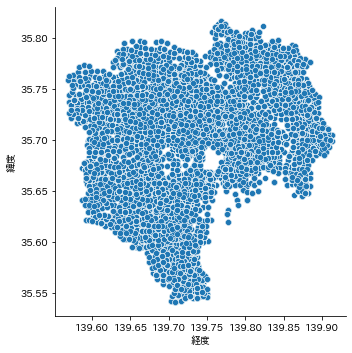

In [146]:
# 緯度経度散布図
# まさに東京23区
sns.relplot(data=suumo_tokyo_new, x='経度', y='緯度')
plt.show()

In [303]:
# 最寄り駅変数（正規表現）

# 最寄り駅から路線と駅を取り出す
suumo_tokyo[['路線','駅']] = suumo_tokyo.apply(lambda x:re.search('(.+)/(.+?)\s(.+)',x.最寄り駅1).groups()[0:2],axis=1,result_type='expand')

def how_to_station():
    # 移動手段は3パターン
    how_to_station = ['歩','バス','車']
    for by in how_to_station:
        # 移動手段変数を生成
        suumo_tokyo[f'{by}'] = np.zeros(suumo_tokyo.shape[0])
        # その移動手段があるなら移動手段変数に格納する
        suumo_tokyo.loc[suumo_tokyo['最寄り駅1'].map(lambda x: search_object(f'{by}[0-9]+分',x)),f'{by}'] = suumo_tokyo.loc[suumo_tokyo['最寄り駅1'].map(lambda x: search_object(f'{by}[0-9]+分',x)),'最寄り駅1'].map(lambda x: re.search(f'{by}([0-9]+)分',x).group(1))
        # 所要時間をint型に変換
        suumo_tokyo[f'{by}'] = suumo_tokyo[f'{by}'].astype(int)

# 移動手段ごとに所用時間変数を作る
how_to_station()

In [306]:
suumo_tokyo

,カテゴリ,建物名,住所,最寄り駅1,最寄り駅2,最寄り駅3,築年数,階数,階,賃料,...,地下,地上,都道府県,市区町村,市区町村以下,路線,駅,歩,バス,車
0,賃貸アパート,プチ・ボヌール,東京都大田区南蒲田３,京急空港線/糀谷駅 歩7分,京急本線/京急蒲田駅 歩10分,京急本線/雑色駅 歩16分,4,2,2.0,14.8,...,0,2,東京都,大田区,南蒲田３,京急空港線,糀谷駅,7,0,0
1,賃貸一戸建て,荒川戸建,東京都荒川区荒川２,東京メトロ千代田線/町屋駅 歩5分,京成本線/新三河島駅 歩12分,ＪＲ常磐線/三河島駅 歩15分,10,3,3.0,19.5,...,0,3,東京都,荒川区,荒川２,東京メトロ千代田線,町屋駅,5,0,0
2,賃貸一戸建て,荒川戸建,東京都荒川区荒川２,東京メトロ千代田線/町屋駅 歩5分,京成本線/新三河島駅 歩12分,ＪＲ常磐線/三河島駅 歩15分,10,3,3.0,19.5,...,0,3,東京都,荒川区,荒川２,東京メトロ千代田線,町屋駅,5,0,0
3,賃貸マンション,ティモーネ上野の森ノース,東京都荒川区東日暮里４,ＪＲ山手線/鶯谷駅 歩6分,東京メトロ日比谷線/入谷駅 歩11分,ＪＲ山手線/日暮里駅 歩13分,5,11,2.0,15.2,...,0,11,東京都,荒川区,東日暮里４,ＪＲ山手線,鶯谷駅,6,0,0
4,賃貸アパート,東京メトロ日比谷線 三ノ輪駅 3階建 築13年,東京都荒川区南千住５,東京メトロ日比谷線/三ノ輪駅 歩5分,ＪＲ常磐線/南千住駅 歩7分,京成本線/千住大橋駅 歩15分,13,3,3.0,11.3,...,0,3,東京都,荒川区,南千住５,東京メトロ日比谷線,三ノ輪駅,5,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
222918,賃貸一戸建て,中澤貸家,東京都江戸川区江戸川２,都営新宿線/瑞江駅 歩14分,NaN,NaN,51,2,2.0,8.4,...,0,2,東京都,江戸川区,江戸川２,都営新宿線,瑞江駅,14,0,0
222919,賃貸マンション,東京メトロ副都心線 雑司が谷駅 7階建 築37年,東京都豊島区高田１,東京メトロ副都心線/雑司が谷駅 歩4分,ＪＲ山手線/目白駅 歩11分,東京メトロ有楽町線/護国寺駅 歩15分,37,7,7.0,9.2,...,0,7,東京都,豊島区,高田１,東京メトロ副都心線,雑司が谷駅,4,0,0
222920,賃貸アパート,ハイツ南大井,東京都品川区南大井５,京急本線/立会川駅 歩7分,ＪＲ京浜東北線/大井町駅 歩14分,ＪＲ京浜東北線/大森駅 歩14分,20,2,1.0,8.5,...,0,2,東京都,品川区,南大井５,京急本線,立会川駅,7,0,0
222921,賃貸マンション,芦間ハイツ,東京都葛飾区東新小岩１,ＪＲ総武線/新小岩駅 歩3分,NaN,NaN,45,3,3.0,7.5,...,0,3,東京都,葛飾区,東新小岩１,ＪＲ総武線,新小岩駅,3,0,0


In [307]:
# 順番を見やすいように入れ替える
columns = ['カテゴリ','建物名','経度','緯度','都道府県','市区町村','市区町村以下','路線','駅','歩','バス','車','築年数','地上','地下','階数','階','賃料','管理費','敷金','礼金','間取り','専有面積','url']
suumo_tokyo_shaped = suumo_tokyo[columns]
# 重複を削除する（重複10000くらいありましたね…）
suumo_tokyo_shaped = suumo_tokyo_shaped[suumo_tokyo_shaped.duplicated() == False]
# 保存
suumo_tokyo_shaped.to_csv('SuumoTokyoShaped20221017.csv', index=False)

In [308]:
columns = ['カテゴリ','建物名','経度','緯度','都道府県','市区町村','市区町村以下','路線','駅','歩','バス','車','築年数','地上','地下','階数','階','賃料','管理費','敷金','礼金','間取り','専有面積']
suumo_tokyo_shaped[columns]

# suumo_tokyo_shaped['階']/suumo_tokyo_shaped['階数']

,カテゴリ,建物名,経度,緯度,都道府県,市区町村,市区町村以下,路線,駅,歩,...,地上,地下,階数,階,賃料,管理費,敷金,礼金,間取り,専有面積
0,賃貸アパート,プチ・ボヌール,139.726883,35.554230,東京都,大田区,南蒲田３,京急空港線,糀谷駅,7,...,2,0,2,2.0,14.8,5000,14.8,14.8,42DK,48.87
1,賃貸一戸建て,荒川戸建,139.783234,35.737568,東京都,荒川区,荒川２,東京メトロ千代田線,町屋駅,5,...,3,0,3,3.0,19.5,0,39.0,19.5,3SLDK,97.95
2,賃貸一戸建て,荒川戸建,139.783234,35.737568,東京都,荒川区,荒川２,東京メトロ千代田線,町屋駅,5,...,3,0,3,3.0,19.5,0,39.0,19.5,3SLDK,97.95
3,賃貸マンション,ティモーネ上野の森ノース,139.780899,35.726601,東京都,荒川区,東日暮里４,ＪＲ山手線,鶯谷駅,6,...,11,0,11,2.0,15.2,10000,15.2,15.2,2LDK,52.04
4,賃貸アパート,東京メトロ日比谷線 三ノ輪駅 3階建 築13年,139.795654,35.733616,東京都,荒川区,南千住５,東京メトロ日比谷線,三ノ輪駅,5,...,3,0,3,3.0,11.3,2000,11.3,11.3,1LDK,43.81
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
222913,賃貸マンション,メゾンスギモト,139.892426,35.720993,東京都,江戸川区,東小岩１,ＪＲ総武線,小岩駅,20,...,3,0,3,3.0,8.5,0,8.5,8.5,2DK,40.00
222915,賃貸マンション,大場ビル,139.880020,35.700130,東京都,江戸川区,西一之江２,都営新宿線,一之江駅,26,...,3,0,3,2.0,8.6,4000,0.0,0.0,2LDK,47.25
222918,賃貸一戸建て,中澤貸家,139.902374,35.685436,東京都,江戸川区,江戸川２,都営新宿線,瑞江駅,14,...,2,0,2,2.0,8.4,0,16.8,0.0,3K,52.87
222919,賃貸マンション,東京メトロ副都心線 雑司が谷駅 7階建 築37年,139.716156,35.715145,東京都,豊島区,高田１,東京メトロ副都心線,雑司が谷駅,4,...,7,0,7,7.0,9.2,8000,9.2,9.2,1DK,26.04


In [309]:
pd.read_csv('SuumoTokyoShaped20221017.csv')

,カテゴリ,建物名,経度,緯度,都道府県,市区町村,市区町村以下,路線,駅,歩,...,地下,階数,階,賃料,管理費,敷金,礼金,間取り,専有面積,url
0,賃貸アパート,プチ・ボヌール,139.726883,35.554230,東京都,大田区,南蒲田３,京急空港線,糀谷駅,7,...,0,2,2.0,14.8,5000,14.8,14.8,42DK,48.87,https://suumo.jp/chintai/jnc_000046696863/?bc=...
1,賃貸一戸建て,荒川戸建,139.783234,35.737568,東京都,荒川区,荒川２,東京メトロ千代田線,町屋駅,5,...,0,3,3.0,19.5,0,39.0,19.5,3SLDK,97.95,https://suumo.jp/chintai/jnc_000076009318/?bc=...
2,賃貸一戸建て,荒川戸建,139.783234,35.737568,東京都,荒川区,荒川２,東京メトロ千代田線,町屋駅,5,...,0,3,3.0,19.5,0,39.0,19.5,3SLDK,97.95,https://suumo.jp/chintai/jnc_000076047600/?bc=...
3,賃貸マンション,ティモーネ上野の森ノース,139.780899,35.726601,東京都,荒川区,東日暮里４,ＪＲ山手線,鶯谷駅,6,...,0,11,2.0,15.2,10000,15.2,15.2,2LDK,52.04,https://suumo.jp/chintai/jnc_000077318759/?bc=...
4,賃貸アパート,東京メトロ日比谷線 三ノ輪駅 3階建 築13年,139.795654,35.733616,東京都,荒川区,南千住５,東京メトロ日比谷線,三ノ輪駅,5,...,0,3,3.0,11.3,2000,11.3,11.3,1LDK,43.81,https://suumo.jp/chintai/jnc_000077330023/?bc=...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
156938,賃貸マンション,メゾンスギモト,139.892426,35.720993,東京都,江戸川区,東小岩１,ＪＲ総武線,小岩駅,20,...,0,3,3.0,8.5,0,8.5,8.5,2DK,40.00,https://suumo.jp/chintai/jnc_000069889741/?bc=...
156939,賃貸マンション,大場ビル,139.880020,35.700130,東京都,江戸川区,西一之江２,都営新宿線,一之江駅,26,...,0,3,2.0,8.6,4000,0.0,0.0,2LDK,47.25,https://suumo.jp/chintai/jnc_000019146531/?bc=...
156940,賃貸一戸建て,中澤貸家,139.902374,35.685436,東京都,江戸川区,江戸川２,都営新宿線,瑞江駅,14,...,0,2,2.0,8.4,0,16.8,0.0,3K,52.87,https://suumo.jp/chintai/jnc_000070035188/?bc=...
156941,賃貸マンション,東京メトロ副都心線 雑司が谷駅 7階建 築37年,139.716156,35.715145,東京都,豊島区,高田１,東京メトロ副都心線,雑司が谷駅,4,...,0,7,7.0,9.2,8000,9.2,9.2,1DK,26.04,https://suumo.jp/chintai/jnc_000074167859/?bc=...


In [312]:
# せっかくなので駅→住所→緯度経度変換できるようにしたい
# ここは駅に対応する住所を回収する場所

url = 'https://www.navitime.co.jp/category/0802001/13/?page={}'
max_page = 44
running_times = []
soup_tank = []

for page in range(1,max_page+1):
    
    start = time.time()
    
    load_url = url.format(page)
    html = requests.get(load_url)
    soup = BeautifulSoup(html.content, 'html.parser')
    soup_tank.append(soup)
    time.sleep(1)
    
    finish = time.time()
    
    running_time = finish - start
    running_times.append(running_time)

    all_count = max_page
    print(f'{page}件目：{running_time}秒')
    # 作業進捗
    complete_ratio = round(page/all_count*100,3)
    print(f'完了：{complete_ratio}%')
    # 作業の残り時間目安を表示
    running_mean = np.mean(running_times)
    running_required_time = running_mean * (all_count - page)
    hour = int(running_required_time/3600)
    minute = int((running_required_time%3600)/60)
    second = int(running_required_time%60)
    print(f'残り時間：{hour}時間{minute}分{second}秒\n')

1件目：1.2461917400360107秒
完了：2.273%
残り時間：0時間0分53秒



KeyboardInterrupt: 

In [255]:
# 回収したhtmlデータから駅と住所の対応を回収する
# csvに保存したので2回目は不要

all_sta_add = []

for page in range(max_page):
    stations = []
    for item in soup_tank[page].find_all(class_='spot-name-text'):
        stations.append(item.text)

    addresses = []
    for item in soup_tank[page].find_all(class_='spot-detail-value-text'):
        isaddress = re.match('東京都',item.text)
        if isaddress :
            addresses.append(item.text)

    sta_add = np.c_[stations, addresses]
    
    if page == 0:
        all_sta_add = sta_add
    else:
        all_sta_add = np.r_[all_sta_add,sta_add]
        
# データをcsvに保存
pd.DataFrame(all_sta_add,columns=['駅','住所']).to_csv('station_address.csv',index=False)

In [314]:
# 駅と住所の対応表
all_sta_add = pd.read_csv('station_address.csv')

In [319]:
# 駅の住所→緯度経度の対応を回収したい
all_addresses = {}
running_times = []
i = 0

for address in all_sta_add['住所']:
    
    start = time.time()

    coordinate = translate_address_coordinates(address)
    all_addresses[address] = coordinate
    time.sleep(1)
    
    finish = time.time()
    
    running_time = finish - start
    running_times.append(running_time)

    all_count = all_sta_add['住所'].shape[0]
    print(f'{i}件目：{running_time}秒')
    # 作業進捗
    complete_ratio = round(i/all_count*100,3)
    print(f'完了：{complete_ratio}%')
    # 作業の残り時間目安を表示
    running_mean = np.mean(running_times)
    running_required_time = running_mean * (all_count - i)
    hour = int(running_required_time/3600)
    minute = int((running_required_time%3600)/60)
    second = int(running_required_time%60)
    print(f'残り時間：{hour}時間{minute}分{second}秒\n')
    i += 1

0件目：1.0951859951019287秒
完了：0.0%
残り時間：0時間12分1秒

1件目：1.0810072422027588秒
完了：0.152%
残り時間：0時間11分55秒

2件目：1.0685820579528809秒
完了：0.303%
残り時間：0時間11分50秒

3件目：1.066068410873413秒
完了：0.455%
残り時間：0時間11分46秒

4件目：1.0673069953918457秒
完了：0.607%
残り時間：0時間11分44秒

5件目：1.1380999088287354秒
完了：0.759%
残り時間：0時間11分50秒

6件目：1.1092309951782227秒
完了：0.91%
残り時間：0時間11分51秒

7件目：1.1332294940948486秒
完了：1.062%
残り時間：0時間11分53秒

8件目：1.1489779949188232秒
完了：1.214%
残り時間：0時間11分56秒

9件目：1.2107934951782227秒
完了：1.366%
残り時間：0時間12分2秒

10件目：1.151536464691162秒
完了：1.517%
残り時間：0時間12分3秒

11件目：1.121358871459961秒
完了：1.669%
残り時間：0時間12分3秒

12件目：1.1191651821136475秒
完了：1.821%
残り時間：0時間12分2秒

13件目：1.179422378540039秒
完了：1.973%
残り時間：0時間12分3秒

14件目：1.15004563331604秒
完了：2.124%
残り時間：0時間12分4秒

15件目：1.1457774639129639秒
完了：2.276%
残り時間：0時間12分3秒

16件目：1.1468892097473145秒
完了：2.428%
残り時間：0時間12分3秒

17件目：1.1397640705108643秒
完了：2.58%
残り時間：0時間12分3秒

18件目：1.1171422004699707秒
完了：2.731%
残り時間：0時間12分1秒

19件目：1.1036062240600586秒
完了：2.883%
残り時間：0時間11分59秒

20件目：1.1232

161件目：1.1049461364746094秒
完了：24.431%
残り時間：0時間9分23秒

162件目：1.101161003112793秒
完了：24.583%
残り時間：0時間9分22秒

163件目：1.1082017421722412秒
完了：24.734%
残り時間：0時間9分21秒

164件目：1.1617205142974854秒
完了：24.886%
残り時間：0時間9分20秒

165件目：1.1029770374298096秒
完了：25.038%
残り時間：0時間9分18秒

166件目：1.113562822341919秒
完了：25.19%
残り時間：0時間9分17秒

167件目：1.1342766284942627秒
完了：25.341%
残り時間：0時間9分16秒

168件目：1.105492353439331秒
完了：25.493%
残り時間：0時間9分15秒

169件目：1.142017126083374秒
完了：25.645%
残り時間：0時間9分14秒

170件目：1.181577205657959秒
完了：25.797%
残り時間：0時間9分13秒

171件目：1.1659235954284668秒
完了：25.948%
残り時間：0時間9分12秒

172件目：1.1525239944458008秒
完了：26.1%
残り時間：0時間9分11秒

173件目：1.1708340644836426秒
完了：26.252%
残り時間：0時間9分10秒

174件目：1.1502056121826172秒
完了：26.404%
残り時間：0時間9分9秒

175件目：1.114764928817749秒
完了：26.555%
残り時間：0時間9分7秒

176件目：1.1006577014923096秒
完了：26.707%
残り時間：0時間9分6秒

177件目：1.1771736145019531秒
完了：26.859%
残り時間：0時間9分5秒

178件目：1.1409077644348145秒
完了：27.011%
残り時間：0時間9分4秒

179件目：1.152463436126709秒
完了：27.162%
残り時間：0時間9分3秒

180件目：1.1683151721954346秒
完了

321件目：1.146953821182251秒
完了：48.71%
残り時間：0時間6分23秒

322件目：1.1995337009429932秒
完了：48.862%
残り時間：0時間6分22秒

323件目：1.177856206893921秒
完了：49.014%
残り時間：0時間6分21秒

324件目：1.166142463684082秒
完了：49.165%
残り時間：0時間6分20秒

325件目：1.1478488445281982秒
完了：49.317%
残り時間：0時間6分19秒

326件目：1.112377643585205秒
完了：49.469%
残り時間：0時間6分18秒

327件目：1.1629953384399414秒
完了：49.621%
残り時間：0時間6分17秒

328件目：1.1655230522155762秒
完了：49.772%
残り時間：0時間6分16秒

329件目：1.0969796180725098秒
完了：49.924%
残り時間：0時間6分14秒

330件目：1.0942506790161133秒
完了：50.076%
残り時間：0時間6分13秒

331件目：1.190943717956543秒
完了：50.228%
残り時間：0時間6分12秒

332件目：2.6040072441101074秒
完了：50.379%
残り時間：0時間6分12秒

333件目：2.020730972290039秒
完了：50.531%
残り時間：0時間6分12秒

334件目：1.1622235774993896秒
完了：50.683%
残り時間：0時間6分11秒

335件目：1.1596269607543945秒
完了：50.835%
残り時間：0時間6分10秒

336件目：1.149139642715454秒
完了：50.986%
残り時間：0時間6分9秒

337件目：1.1048314571380615秒
完了：51.138%
残り時間：0時間6分8秒

338件目：1.1606483459472656秒
完了：51.29%
残り時間：0時間6分7秒

339件目：1.1706507205963135秒
完了：51.442%
残り時間：0時間6分5秒

340件目：1.1505239009857178秒

481件目：1.1190438270568848秒
完了：72.989%
残り時間：0時間3分24秒

482件目：1.0663855075836182秒
完了：73.141%
残り時間：0時間3分23秒

483件目：1.143885612487793秒
完了：73.293%
残り時間：0時間3分22秒

484件目：1.1398379802703857秒
完了：73.445%
残り時間：0時間3分20秒

485件目：1.112541913986206秒
完了：73.596%
残り時間：0時間3分19秒

486件目：1.144625186920166秒
完了：73.748%
残り時間：0時間3分18秒

487件目：1.1284780502319336秒
完了：73.9%
残り時間：0時間3分17秒

488件目：1.129136085510254秒
完了：74.052%
残り時間：0時間3分16秒

489件目：1.1453471183776855秒
完了：74.203%
残り時間：0時間3分15秒

490件目：1.1341392993927002秒
完了：74.355%
残り時間：0時間3分13秒

491件目：1.1543772220611572秒
完了：74.507%
残り時間：0時間3分12秒

492件目：1.1427350044250488秒
完了：74.659%
残り時間：0時間3分11秒

493件目：1.0977518558502197秒
完了：74.81%
残り時間：0時間3分10秒

494件目：1.0823440551757812秒
完了：74.962%
残り時間：0時間3分9秒

495件目：1.113551378250122秒
完了：75.114%
残り時間：0時間3分8秒

496件目：1.129460096359253秒
完了：75.266%
残り時間：0時間3分6秒

497件目：1.112229585647583秒
完了：75.417%
残り時間：0時間3分5秒

498件目：1.1210646629333496秒
完了：75.569%
残り時間：0時間3分4秒

499件目：1.0654940605163574秒
完了：75.721%
残り時間：0時間3分3秒

500件目：1.5846011638641357秒
完了

641件目：1.1296918392181396秒
完了：97.269%
残り時間：0時間0分20秒

642件目：1.133716106414795秒
完了：97.42%
残り時間：0時間0分19秒

643件目：1.154895305633545秒
完了：97.572%
残り時間：0時間0分18秒

644件目：1.0783188343048096秒
完了：97.724%
残り時間：0時間0分17秒

645件目：1.0991711616516113秒
完了：97.876%
残り時間：0時間0分16秒

646件目：1.129448413848877秒
完了：98.027%
残り時間：0時間0分14秒

647件目：1.0862443447113037秒
完了：98.179%
残り時間：0時間0分13秒

648件目：1.1514246463775635秒
完了：98.331%
残り時間：0時間0分12秒

649件目：1.134711742401123秒
完了：98.483%
残り時間：0時間0分11秒

650件目：1.1513028144836426秒
完了：98.634%
残り時間：0時間0分10秒

651件目：1.1313433647155762秒
完了：98.786%
残り時間：0時間0分9秒

652件目：1.1412405967712402秒
完了：98.938%
残り時間：0時間0分8秒

653件目：1.1411983966827393秒
完了：99.09%
残り時間：0時間0分6秒

654件目：1.0777668952941895秒
完了：99.241%
残り時間：0時間0分5秒

655件目：1.1301052570343018秒
完了：99.393%
残り時間：0時間0分4秒

656件目：1.095757246017456秒
完了：99.545%
残り時間：0時間0分3秒

657件目：1.0816314220428467秒
完了：99.697%
残り時間：0時間0分2秒

658件目：1.1163699626922607秒
完了：99.848%
残り時間：0時間0分1秒



In [321]:
# 駅の住所と緯度経度のDataFrame
# これもcsvに保存済なので2回目は不要
coordinates = pd.DataFrame(all_addresses).T
coordinates.reset_index(inplace=True)
coordinates.rename(columns={
    'index':'住所',
    0:'経度',
    1:'緯度'
}, inplace=True)
coordinates.to_csv('station_coordinates.csv',index=False)

In [347]:
# せっかくなので23区も区役所から区名→住所→緯度経度変換したい
# 23区の区役所住所を取得
url = 'https://www.homemate-research-public.com/bc09/13100/list/'
html = requests.get(url)
soup = BeautifulSoup(html.content, 'html.parser')

In [377]:
# 区名を取り出す
ku_names = soup.find_all(class_='fa_name')
names = []
for item in ku_names:
    name = item.text
    names.append(name)

# 住所を取り出す
place = soup.find_all(class_='fa_inner')

addresses = []
for item in place:
    address = item.find(class_='fa_address').find_all('span')[1].text
    address = re.search('(東京都.+[０-９])|(東京都.+[0-9])',address).group()
    addresses.append(address)

In [380]:
# 区名と住所の対応表
ku_addresses = np.c_[names,addresses]

In [11]:
pip install geocoder

Note: you may need to restart the kernel to use updated packages.


In [14]:
import geocoder
location = '東京都大田区南蒲田3'
ret = geocoder.osm(location, timeout=5.0)
print(ret.latlng)
print(ret.address)

None
None
